In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
import pandas as pd
import itertools
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error


In [18]:
from RAGE import RAGE
from XY_ORACLE import XY_ORACLE
from XY_STATIC import XY_STATIC
from RAGE_opt import RAGE_opt
from RAGE_center import RAGE_center

In [19]:
import logging

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
    
logging.basicConfig(level=logging.CRITICAL, format='%(message)s')

logging.debug("This is a debug message and should not appear.")
logging.critical("This is a critical message and should appear.")


This is a critical message and should appear.


In [20]:
x_path = "/homes/gws/sqhang/proj/2024_sqhang_Transductive-bandits/data/tf_bind_8-x-0.npy"
x_arr = np.load(x_path, allow_pickle=True)
print(x_arr.shape)
print(x_arr[0, :])
y_path = "/homes/gws/sqhang/proj/2024_sqhang_Transductive-bandits/data/tf_bind_8-y-0.npy"
y_arr = np.load(y_path, allow_pickle=True)
print(y_arr.shape)
print(y_arr[0])

(65792, 8)
[0 0 0 0 0 0 0 0]
(65792, 1)
[0.5247495]


### Train/test split

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_arr, y_arr, test_size=0.3, random_state=42)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (46054, 8)
Shape of x_test: (19738, 8)
Shape of y_train: (46054, 1)
Shape of y_test: (19738, 1)


### Helper functions

In [22]:
def compute_correlations(y_true, y_pred):
    """
    Compute Pearson and Spearman correlations between the true and predicted values.
    
    Parameters:
    - y_true: array-like, true target values
    - y_pred: array-like, predicted target values
    
    Returns:
    - A dictionary containing Pearson and Spearman correlation coefficients
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    pearson_corr, _ = pearsonr(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)
    
    return {'Pearson': pearson_corr, 'Spearman': spearman_corr}

### Fit a naive linear model

In [23]:
model = LinearRegression()
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

train_correlations = compute_correlations(y_train, y_train_pred)
print("Training Correlations:", train_correlations)

test_correlations = compute_correlations(y_test, y_test_pred)
print("Testing Correlations:", test_correlations)

Training Correlations: {'Pearson': 0.01601073418417917, 'Spearman': 0.015776977942408565}
Testing Correlations: {'Pearson': -0.005421148809469955, 'Spearman': -0.0018245756766438537}


Whoops! Barely no correlations. Let's try with a more meaningful featurization.

### Kmer Linear Regression

In [24]:
def make_kmer_list(k, alphabet="ACGT", upto=False):
    """Generate sorted list of k-mers for each k up to the given k, considering reverse complements."""
    kmer_dict = {}
    if upto:
        range_k = range(1, k + 1)
    else:
        range_k = [k]
    for current_k in range_k:
        kmer_set = set()
        for kmer_tuple in itertools.product(alphabet, repeat=current_k):
            kmer = ''.join(kmer_tuple)
            rev_kmer = ''.join(reversed([{'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}[x] for x in kmer]))
            kmer_set.add(min(kmer, rev_kmer))
        kmer_dict[current_k] = sorted(kmer_set)
    # Flatten dictionary into a list while preserving order by k-mer length
    kmer_list = [kmer for sublist in range_k for kmer in kmer_dict[sublist]]
    return kmer_list, kmer_dict

In [25]:
### Counting k-mers
def count_kmers(sequences, k, normalize=None, upto=False):
    """Count k-mers in sequences for all lengths up to k if 'upto' is True, and optionally normalize the counts."""
    alphabet = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
    num_sequences = sequences.shape[0]
    kmer_list, kmer_dict = make_kmer_list(k, alphabet="ACGT", upto=upto)
    kmer_index = {kmer: idx for idx, kmer in enumerate(kmer_list)}
    kmer_matrix = np.zeros((num_sequences, len(kmer_list)), dtype=float)  # Changed dtype to float

    # Convert sequences to strings and count k-mers
    for i in range(num_sequences):
        sequence = ''.join(alphabet[b] for b in sequences[i])
        for current_k, kmers in kmer_dict.items():
            for j in range(len(sequence) - current_k + 1):
                kmer = sequence[j:j+current_k]
                rev_kmer = ''.join(reversed([{'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}[x] for x in kmer]))
                canonical_kmer = min(kmer, rev_kmer)
                if canonical_kmer in kmer_index:
                    kmer_matrix[i, kmer_index[canonical_kmer]] += 1

    if normalize:
        if normalize == "frequency":
            # Normalize separately for each k-length group
            for current_k, kmers in kmer_dict.items():
                indices = [kmer_index[kmer] for kmer in kmers]
                sums = kmer_matrix[:, indices].sum(axis=1, keepdims=True)
                kmer_matrix[:, indices] /= np.maximum(1, sums)
        elif normalize == "unitsphere":
            for current_k, kmers in kmer_dict.items():
                indices = [kmer_index[kmer] for kmer in kmers]
                norms = np.linalg.norm(kmer_matrix[:, indices], axis=1, keepdims=True)
                kmer_matrix[:, indices] /= np.maximum(1e-10, norms)

    return kmer_matrix

In [26]:
k = 4
x_train_kmer = count_kmers(x_train, k, normalize='frequency', upto=True)
print(x_train_kmer.shape)

(46054, 180)


In [27]:
k = 4
x_test_kmer = count_kmers(x_test, k, normalize='frequency', upto=True)
print(x_test_kmer.shape)

(19738, 180)


In [42]:
model_kmer = LinearRegression(fit_intercept=False)
model_kmer.fit(x_train_kmer, y_train)

y_train_pred_kmer = model_kmer.predict(x_train_kmer)
y_test_pred_kmer = model_kmer.predict(x_test_kmer)

kmer_train_correlations = compute_correlations(y_train, y_train_pred_kmer)
print("Training Correlations:", kmer_train_correlations)

kmer_test_correlations = compute_correlations(y_test, y_test_pred_kmer)
print("Testing Correlations:", kmer_test_correlations)

Training Correlations: {'Pearson': 0.84363220050202, 'Spearman': 0.7866156930574246}
Testing Correlations: {'Pearson': 0.8478971871172449, 'Spearman': 0.7855282570710911}


In [43]:
theta_star = model_kmer.coef_
intercept = model_kmer.intercept_
print(theta_star.T.shape)
print(intercept)

(180, 1)
0.0


In [38]:
# Further split training set to create item set(full train set) and prob set
_, x_probe_kmer, _, y_probe = train_test_split(x_train_kmer, y_train, test_size=0.1, random_state=42)

In [39]:
print(x_probe_kmer.shape)
print(y_probe.shape)

(4606, 180)
(4606, 1)


In [40]:
Z = x_train_kmer
X = x_probe_kmer
Z_val = y_train
X_val = y_probe

In [41]:
model_kmer = LinearRegression(fit_intercept=False)
model_kmer.fit(X, X_val)

y_train_pred_kmer = model_kmer.predict(X)
y_test_pred_kmer = model_kmer.predict(Z)

kmer_train_correlations = compute_correlations(X_val, y_train_pred_kmer)
print("Training Correlations:", kmer_train_correlations)

kmer_test_correlations = compute_correlations(Z_val, y_test_pred_kmer)
print("Testing Correlations:", kmer_test_correlations)

Training Correlations: {'Pearson': 0.8503329861795845, 'Spearman': 0.7955707154295134}
Testing Correlations: {'Pearson': 0.8377279737906627, 'Spearman': 0.7783581956506994}


In [15]:
model_kmer

LinearRegression(fit_intercept=False)

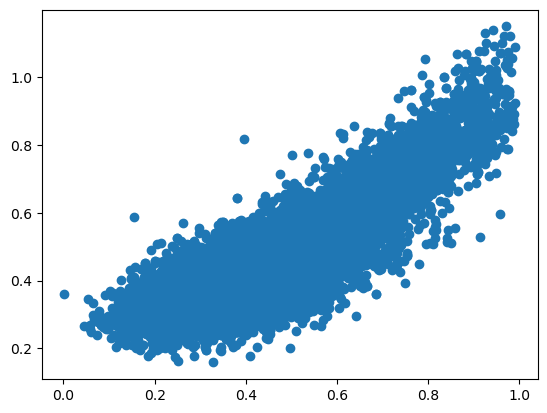

In [16]:
plt.scatter(y_test, y_test_pred_kmer)
plt.show()

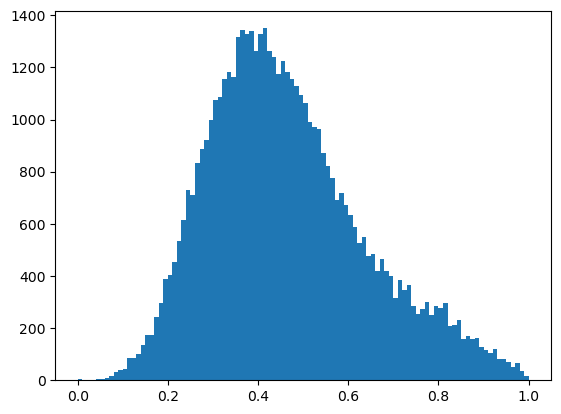

In [17]:
plt.hist(y_train, bins=100)
plt.show()

### Kmer Kernel Methods

In [22]:
model_kmer_krr = KernelRidge(alpha=1.0, kernel='rbf', gamma=0.1)

model_kmer_krr.fit(x_train_kmer, y_train)

KernelRidge(alpha=1.0, gamma=0.1, kernel='rbf')

In [23]:
y_train_pred_kmer_krr = model_kmer_krr.predict(x_train_kmer)
y_test_pred_kmer_krr = model_kmer_krr.predict(x_test_kmer)

# Compute correlations or other performance metrics
kmer_train_correlations_krr = compute_correlations(y_train, y_train_pred_kmer_krr)
kmer_test_correlations_krr = compute_correlations(y_test, y_test_pred_kmer_krr)

print("Training Correlations (KRR):", kmer_train_correlations_krr)
print("Testing Correlations (KRR):", kmer_test_correlations_krr)

Training Correlations (KRR): {'Pearson': 0.8698403407591941, 'Spearman': 0.8153968202744548}
Testing Correlations (KRR): {'Pearson': 0.8712696485314264, 'Spearman': 0.8101305844413605}


In [ ]:
# Hyperparameter search code to run if have time
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.1, 1, 10, 100],
              'gamma': np.logspace(-4, 1, 6)}

grid_search = GridSearchCV(KernelRidge(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(x_train_kmer, y_train)

best_krr_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

### Kmer XGBoost Methods

In [25]:
import xgboost as xgb

In [40]:
x_train_kmer, x_val_kmer, y_train, y_val = train_test_split(
    x_train_kmer, y_train, test_size=0.2, random_state=42
)
print(x_train_kmer.shape)
print(x_val_kmer.shape)

(42106, 692)
(10527, 692)


In [41]:
dtrain = xgb.DMatrix(x_train_kmer, label=y_train)
dval = xgb.DMatrix(x_val_kmer, label=y_val)
dtest = xgb.DMatrix(x_test_kmer, label=y_test)

In [42]:
params = {
    'max_depth': 10,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

In [43]:
num_boost_round = 5000
evals = [(dtrain, 'train'), (dval, 'validation')]
bst = xgb.train(params, dtrain, num_boost_round, evals=evals, early_stopping_rounds=10)

[0]	train-rmse:0.16184	validation-rmse:0.16177
[1]	train-rmse:0.15118	validation-rmse:0.15143
[2]	train-rmse:0.14179	validation-rmse:0.14244
[3]	train-rmse:0.13367	validation-rmse:0.13466
[4]	train-rmse:0.12653	validation-rmse:0.12788
[5]	train-rmse:0.12028	validation-rmse:0.12198
[6]	train-rmse:0.11491	validation-rmse:0.11693
[7]	train-rmse:0.11019	validation-rmse:0.11261
[8]	train-rmse:0.10611	validation-rmse:0.10887
[9]	train-rmse:0.10249	validation-rmse:0.10558
[10]	train-rmse:0.09937	validation-rmse:0.10280
[11]	train-rmse:0.09667	validation-rmse:0.10035
[12]	train-rmse:0.09426	validation-rmse:0.09832
[13]	train-rmse:0.09221	validation-rmse:0.09656
[14]	train-rmse:0.09031	validation-rmse:0.09498
[15]	train-rmse:0.08871	validation-rmse:0.09368
[16]	train-rmse:0.08725	validation-rmse:0.09246
[17]	train-rmse:0.08602	validation-rmse:0.09144
[18]	train-rmse:0.08482	validation-rmse:0.09054
[19]	train-rmse:0.08381	validation-rmse:0.08973
[20]	train-rmse:0.08279	validation-rmse:0.08898
[2

In [44]:
y_train_pred_xgb = bst.predict(dtrain)
y_test_pred_xgb = bst.predict(dtest)

# Assuming compute_correlations is defined to compute your metric of interest
xgb_train_correlations = compute_correlations(y_train, y_train_pred_xgb)
xgb_test_correlations = compute_correlations(y_test, y_test_pred_xgb)

print("Training Correlations (XGBoost):", xgb_train_correlations)
print("Testing Correlations (XGBoost):", xgb_test_correlations)

Training Correlations (XGBoost): {'Pearson': 0.9937048679572801, 'Spearman': 0.9918885296387072}
Testing Correlations (XGBoost): {'Pearson': 0.9413444233301491, 'Spearman': 0.9140121527133677}


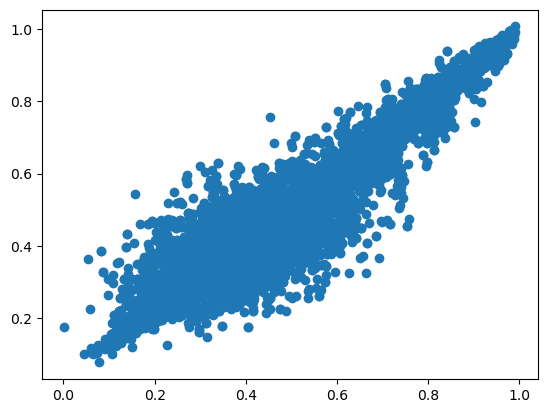

In [47]:
plt.scatter(y_test, y_test_pred_xgb)
plt.show()

### Run RAGE algorithm

RAGE toy example

In [6]:
def transductive_problem_instance(d, rad):
    
    theta_star = np.zeros((d, 1))
    theta_star[0, 0] = 2.0
    X = np.eye(2*d)
    Z = np.eye(2*d)[0:d,:]
    Zp = np.cos(rad)*np.eye(2*d)[0:d,:]+np.sin(rad)*np.eye(2*d)[d:2*d,:] 
    Z = np.vstack((Z, Zp))
    
    theta_star = np.zeros((2*d, 1))
    theta_star[0, 0] = 1
    
    return X, Z, theta_star

In [24]:
count = 20
delta = 0.05
rad = .1
sweep = [20, 40, 60, 80]
factor = 10

X, Z, theta_star = transductive_problem_instance(200, rad)
rage_instance = RAGE(X, theta_star, factor, delta, Z)

In [25]:
rage_instance.algorithm(83)
print(rage_instance.N)

CRITICAL:root:Succeeded? True
CRITICAL:root:Sample complexity 115870


115870


In [26]:
print(theta_star.shape)

(400, 1)


In [24]:
X = x_test_kmer[:200].astype(np.float32)
Z = x_test_kmer[:200].astype(np.float32)
theta_star = theta_hat.T.astype(np.float32)

In [25]:
x_test_kmer.shape

(13159, 180)

In [26]:
X.shape

(200, 180)

In [29]:
factor = 100
delta = 0.10
rage_instance = RAGE(X, theta_star, factor, delta, Z)

In [30]:
rage_instance.algorithm(42)

Starting new iteration with 200 active arms.
Updated delta_t to 0.1 for phase 1.
Inside build_Y, number of active arms: 200 



  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 19265.56it/s]


Built y



  6%|▌         | 3/49 [00:00<00:01, 25.14it/s]

Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allo

 18%|█▊        | 9/49 [00:00<00:01, 26.16it/s]

Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_alloca

 35%|███▍      | 17/49 [00:00<00:01, 30.26it/s]

Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allo

 43%|████▎     | 21/49 [00:00<00:00, 31.11it/s]

Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocatio

 59%|█████▉    | 29/49 [00:00<00:00, 31.97it/s]

Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocatio

 76%|███████▌  | 37/49 [00:01<00:00, 32.44it/s]

Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocatio

 92%|█████████▏| 45/49 [00:01<00:00, 32.64it/s]

Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocatio

100%|██████████| 49/49 [00:01<00:00, 31.21it/s]


Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Inside optimal_allocation, A_inv shape: (180, 180)
Inside optimal_allocation, Ainvhalf shape: (180, 180)
Inside optimal_allocation, newY shape: (40000, 180)
Inside optimal_allocation, rho shape: (40000, 1)
Number of samples required this phase: 48953137


KeyboardInterrupt: 

In [13]:
from RAGE import RAGE
from XY_ORACLE import XY_ORACLE
from XY_STATIC import XY_STATIC
from RAGE_opt import RAGE_opt
from RAGE_center import RAGE_center

### New Real Dataset Test

In [ ]:
count = 20
delta = 0.05
rad = .1
sweep = [20, 40, 60, 80]
factor = 50
seeds = [42, 123, 789]

In [ ]:
rage_dict = {}
xy_static_dict = {}
oracle_dict = {}
rage_opt_dict = {}
rage_center_dict = {}

for d in sweep:
    X, Z, theta_star = transductive_problem_instance(d, rad)
    rage_dict[d] = []
    xy_static_dict[d] = []
    oracle_dict[d] = []
    rage_opt_dict[d] = []
    rage_center_dict[d] = []
    
    for seed in seeds:
        print(d, seed)
        rage_instance = RAGE(X, theta_star, factor, delta, Z)
        rage_instance.algorithm(seed, var=False)
        rage_dict[d].append((rage_instance.success, rage_instance.N))
        
        xy_static_instance = XY_STATIC(X, theta_star, delta, Z)
        xy_static_instance.algorithm(seed)
        xy_static_dict[d].append((xy_static_instance.success, xy_static_instance.N))
        
        oracle_instance = XY_ORACLE(X, theta_star, delta, Z)
        oracle_instance.algorithm(seed)
        oracle_dict[d].append((oracle_instance.success, oracle_instance.N))
        
        rage_opt_instance = RAGE_opt(X, theta_star, factor, delta, Z)
        rage_opt_instance.algorithm(seed, var=False)
        rage_opt_dict[d].append((rage_opt_instance.success, rage_opt_instance.N))
        
        rage_center_instance = RAGE_center(X, theta_star, factor, delta, Z)
        rage_center_instance.algorithm(seed, var=False)
        rage_center_dict[d].append((rage_center_instance.success, rage_center_instance.N))
        

In [44]:
factor = 5
delta = 0.05
rage_center_instance = RAGE_center(X, theta_star.T, factor, delta, Z)
rage_center_instance.algorithm(42, var=False, sigma=0.1, stop_arm_count=5, rel_thresh=0.05)
print(rage_center_instance.N)
print(rage_center_instance.success)

Succeeded? True
Sample complexity 50225


50225
True


In [45]:
factor = 5
delta = 0.05
rage_center_instance = RAGE_opt(X, theta_star.T, factor, delta, Z)
rage_center_instance.algorithm(42, var=False, sigma=0.1, stop_arm_count=5, rel_thresh=0.05)
print(rage_center_instance.N)
print(rage_center_instance.success)

Succeeded? True
Sample complexity 99732


99732
True


In [48]:
factor = 5
delta = 0.05
rage_opt_instance = RAGE_opt(x_train_kmer[:5000,:], theta_star.T, factor, delta, x_train_kmer[:, :])
rage_opt_instance.algorithm(143)

DEBUG:root:design status 143, 100, 0.16455394197471201, 150.39131632735985
DEBUG:root:design status 143, 200, 0.10473314276645468, 113.4669862280937
DEBUG:root:design status 143, 300, 0.07460599154408712, 111.89600376802184
DEBUG:root:design status 143, 400, 0.05666880021771964, 105.9426121632772
INFO:root:


INFO:root:finished phase 1
INFO:root:design [0. 0. 0. ... 0. 0. 0.]
DEBUG:root:allocation [0 0 0 ... 0 0 0]
DEBUG:root:arm counts [0. 0. 0. ... 0. 0. 0.]
INFO:root:round sample count 4102
INFO:root:total sample count 4102
INFO:root:active arms [5772, 16259, 22319, 24832, 25990]
INFO:root:rho 105.01707476854263
INFO:root:


CRITICAL:root:Succeeded? True
CRITICAL:root:Sample complexity 4102


In [61]:
x_test_kmer.shape

(13159, 12)

In [73]:
rage_center_instance.theta_hat.shape

(180, 1)

In [74]:
pred_y_reward = x_test_kmer @ rage_center_instance.theta_hat
pred_y_reward.shape

(13159, 1)

In [75]:
y_test.shape

(13159, 1)

In [41]:
def precision_at_k(pred_y_reward, y_test, k):
    # Ensure inputs are numpy arrays
    pred_y_reward = np.array(pred_y_reward)
    y_test = np.array(y_test)
    
    # Flatten arrays just in case they are not in flat shape
    pred_y_reward = pred_y_reward.flatten()
    y_test = y_test.flatten()

    # Get indices of the sorted predictions (in descending order)
    pred_indices = np.argsort(pred_y_reward)[::-1]

    # Select top p indices from sorted predictions
    top_p_pred_indices = pred_indices[:k]

    # Now find the top p actual values
    actual_indices = np.argsort(y_test)[::-1]
    top_p_actual_indices = set(actual_indices[:k])

    # Check how many of the top p predictions are in the top p actual
    hit_count = sum(idx in top_p_actual_indices for idx in top_p_pred_indices)

    precision = hit_count / k
    return precision * 100


In [47]:
print(precision_at_k(pred_y_reward, y_test, k = 10))
print(precision_at_k(pred_y_reward, y_test, k = 50))
print(precision_at_k(pred_y_reward, y_test, k = 100))

0.0
22.0
34.0


In [53]:
print(precision_at_k(pred_y_reward, y_test, k = 10))
print(precision_at_k(pred_y_reward, y_test, k = 50))
print(precision_at_k(pred_y_reward, y_test, k = 100))

0.0
20.0
33.0


In [66]:
# k = 2
print(precision_at_k(pred_y_reward, y_test, k = 10))
print(precision_at_k(pred_y_reward, y_test, k = 50))
print(precision_at_k(pred_y_reward, y_test, k = 100))

0.0
12.0
15.0


In [78]:
# k = 4
print(precision_at_k(pred_y_reward, y_test, k = 10))
print(precision_at_k(pred_y_reward, y_test, k = 50))
print(precision_at_k(pred_y_reward, y_test, k = 100))

10.0
30.0
38.0
